In [1]:
import numpy as np
import tinyarray as ta
import sympy
from collections import OrderedDict
import kwant
import kwant.continuum
import itertools as it

sympy.init_printing(print_builtin=True)

In [2]:
# For plotting
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
import qsymm

In [4]:
from qsymm.model import _commutative_momenta
from qsymm.groups import generate_group
from qsymm.hamiltonian_generator import hamiltonian_from_family
from qsymm.kwant_integration import kp_to_builder, bloch_model_to_builder, bloch_family_to_builder, builder_to_model

In [5]:
# Spin matrices
S = qsymm.groups.spin_matrices(1/2)

In [6]:
l = [1, 2]

### Test graphene

In [7]:
# Time reversal
TR = qsymm.PointGroupElement(sympy.eye(2), True, False, np.eye(2))

# Chiral symmetry
C = qsymm.PointGroupElement(sympy.eye(2), False, True, np.array([[1, 0], [0, -1]]))

# Atom A rotates into A, B into B.
sphi = 2*sympy.pi/3
RC3 = sympy.Matrix([[sympy.cos(sphi), -sympy.sin(sphi)],
                  [sympy.sin(sphi), sympy.cos(sphi)]])
C3 = qsymm.PointGroupElement(RC3, False, False, np.eye(2))

symmetries = [C, TR, C3]
# symmetries = [TR, C3]

We set the interatom distance to $1$, so the lattice vectors should have norm $\sqrt{3}$

In [8]:
norbs = OrderedDict({'A': 1, 'B': 1})  # A and B atom per unit cell, one orbital each
hopping_vectors = [('A', 'B', [1, 0])] # Hopping between neighbouring A and B atoms

In [9]:
family = qsymm.bloch_family(hopping_vectors, symmetries, norbs)

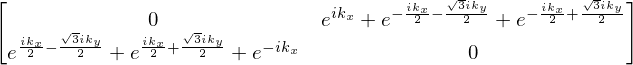

In [10]:
qsymm.display_family(family)

In [11]:
fam = hamiltonian_from_family(family, tosympy=False)

In [12]:
# Atomic coordinates within the unit cell
atom_coords = [(0, 0), (1, 0)]
# We set the interatom distance to 1, so the lattice vectors have length sqrt(3)
lat_vecs = [(3/2, np.sqrt(3)/2), (3/2, -np.sqrt(3)/2)]

In [13]:
fam

{c0*e**(-I*k_x/2 + sqrt(3)*I*k_y/2):
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]],

c0*e**(I*k_x/2 - sqrt(3)*I*k_y/2):
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]],

c0*e**(-I*k_x/2 - sqrt(3)*I*k_y/2):
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]],

c0*e**(I*k_x/2 + sqrt(3)*I*k_y/2):
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]],

c0*e**(I*k_x):
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]],

c0*e**(-I*k_x):
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]],

}

In [14]:
qsymm.model.to_bloch_coeff(list(fam.keys())[0], fam.momenta)

(array([-0.5      ,  0.8660254]), c0)

In [15]:
qsymm.model.BlochModel(fam)

{(array([-0.5      ,  0.8660254]), c0):
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]],

(array([ 0.5      , -0.8660254]), c0):
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]],

(array([-0.5      , -0.8660254]), c0):
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]],

(array([0.5      , 0.8660254]), c0):
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]],

(array([1., 0.]), c0):
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]],

(array([-1.,  0.]), c0):
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]],

}

In [16]:
syst = bloch_model_to_builder(fam, norbs, lat_vecs, atom_coords)
# syst = bloch_model_to_builder(family[0], norbs, lat_vecs, atom_coords)
# g = sympy.Symbol('g', real=True)
# syst = bloch_family_to_builder(family, norbs, lat_vecs, atom_coords, coeffs=[g])

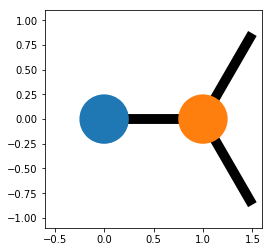

In [17]:
kwant.plot(syst);

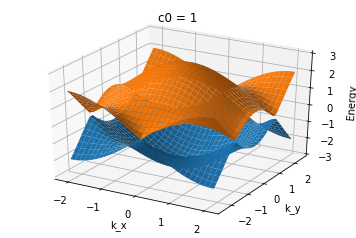

In [18]:
params = dict(c0 = 1)
# params = dict(c0 = 0, c1 = 0, c2 = 1) # if we remove chiral symmetry
# params = dict(g = 1)
wrapped = kwant.wraparound.wraparound(syst).finalized()
kwant.wraparound.plot_2d_bands(wrapped, params=params);

Compare with the correct dispersion

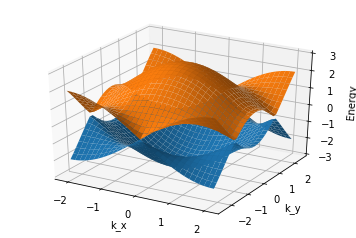

In [19]:
atoms, orbs = zip(*[(atom, norb) for atom, norb in
                    norbs.items()])
# Make the kwant lattice
lat = kwant.lattice.general(lat_vecs,
                            atom_coords,
                            norbs=orbs)
# Store sublattices by name
sublattices = {atom: sublat for atom, sublat in
               zip(atoms, lat.sublattices)}

sym = kwant.TranslationalSymmetry(*lat_vecs)
bulk = kwant.Builder(sym)

bulk[ [sublattices['A'](0, 0), sublattices['B'](0, 0)] ] = 0
bulk[lat.neighbors()] = 1
wrapped = kwant.wraparound.wraparound(bulk).finalized()
kwant.wraparound.plot_2d_bands(wrapped);

Compare model after transforming back

In [20]:
ham2 = builder_to_model(syst).tomodel(nsimplify=True)
assert fam == ham2

In [21]:
fam - ham2

{}

Compare model after transforming back with wraparound's convention

In [22]:
from qsymm.linalg import allclose

ham2 = builder_to_model(syst, unit_cell_convention=True)

# Check that the Hamiltonians are identical at random points in the Brillouin zone
syst = bloch_model_to_builder(fam, norbs, lat_vecs, atom_coords)
wrapped = kwant.wraparound.wraparound(syst).finalized()
H1 = wrapped.hamiltonian_submatrix
H2 = ham2.lambdify()
coeffs = 0.5 + np.random.rand(1)
for _ in range(20):
    kx, ky = 3*np.pi*(np.random.rand(2) - 0.5)
    params = dict(c0=coeffs[0], k_x=kx, k_y=ky)
    h1, h2 = H1(params=params), H2(**params)
    assert allclose(h1, h2), (h1, h2)


In [23]:
norbs = OrderedDict({'A': 1, 'B': 1})  # A and B atom per unit cell, one orbital each
atoms, orbs = zip(*[(atom, norb) for atom, norb in
                    norbs.items()])
# Make the kwant lattice
lat = kwant.lattice.general(lat_vecs,
                            atom_coords,
                            norbs=orbs)
# Store sublattices by name
sublattices = {atom: sublat for atom, sublat in
               zip(atoms, lat.sublattices)}

sym = kwant.TranslationalSymmetry(*lat_vecs)
bulk = kwant.Builder(sym)

bulk[ [sublattices['A'](0, 0), sublattices['B'](0, 0)] ] = 0

def hop(site1, site2, c0):
    return c0

bulk[lat.neighbors()] = hop

wrapped = kwant.wraparound.wraparound(bulk).finalized()
ham2 = builder_to_model(bulk, unit_cell_convention=True)
# Check that the Hamiltonians are identical at random points in the Brillouin zone
H1 = wrapped.hamiltonian_submatrix
H2 = ham2.lambdify()
coeffs = 0.5 + np.random.rand(1)
for _ in range(20):
    kx, ky = 3*np.pi*(np.random.rand(2) - 0.5)
    params = dict(c0=coeffs[0], k_x=kx, k_y=ky)
    h1, h2 = H1(params=params), H2(**params)
    assert allclose(h1, h2), (h1, h2)


### Test MX$_2$

In [24]:
# Time reversal
TR = qsymm.PointGroupElement(sympy.eye(2), True, False, np.eye(3))

# Mirror symmetry 
Mx = qsymm.PointGroupElement(sympy.Matrix([[-1, 0], [0, 1]]), False, False, np.diag([1, -1, 1]))

# Threefold rotation on d_z^2, d_xy, d_x^2-y^2 states.
C3U = np.array([[1, 0, 0],
                 [0, -0.5, -np.sqrt(3)/2],
                 [0, np.sqrt(3)/2, -0.5]])
# Could also use the predefined representation of rotations on d-orbitals
Ld = qsymm.groups.L_matrices(3, 2)
C3U2 = qsymm.groups.spin_rotation(2 * np.pi * np.array([0, 0, 1/3]), Ld)
# Restrict to d_z^2, d_xy, d_x^2-y^2 states
mask = np.array([1, 2 ,0])
C3U2 = C3U2[mask][:, mask]
assert np.allclose(C3U, C3U2)

# The spatial part of the symmetry must be provided as a symbolic matrix
# or an integer array
sphi = 2*sympy.pi/3
C3R = sympy.Matrix([[sympy.cos(sphi), -sympy.sin(sphi)],
                     [sympy.sin(sphi), sympy.cos(sphi)]])
C3 = qsymm.PointGroupElement(C3R, False, False, C3U)

symmetries = [TR, Mx, C3]

In [25]:
# One site per unit cell (M atom), with three orbitals
norbs = OrderedDict({'M': 3})

In [26]:
# Hopping to a neighbouring atom one primitive lattice vector away
hopping_vectors = [('M', 'M', [1, 0])]

In [27]:
family = qsymm.bloch_family(hopping_vectors, symmetries, norbs)

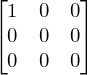

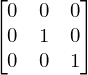

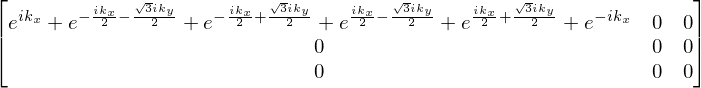

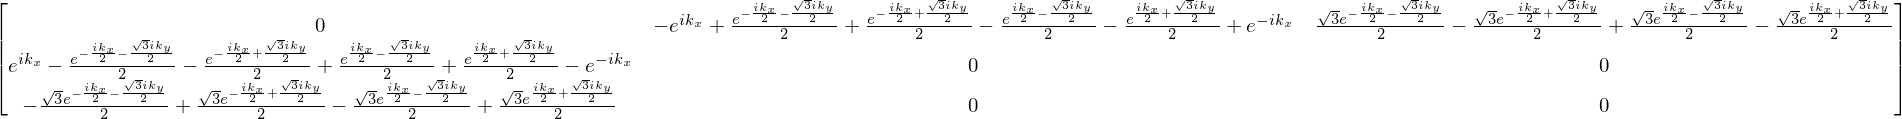

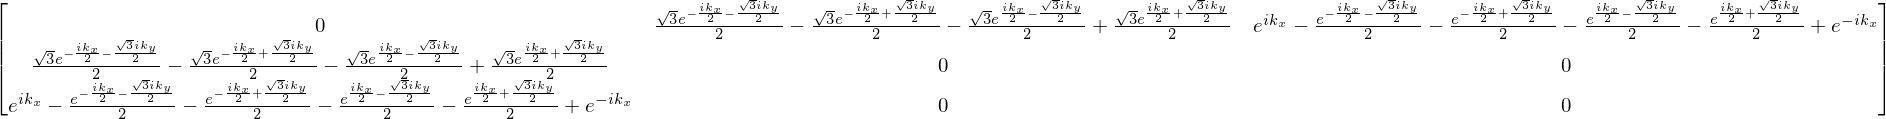

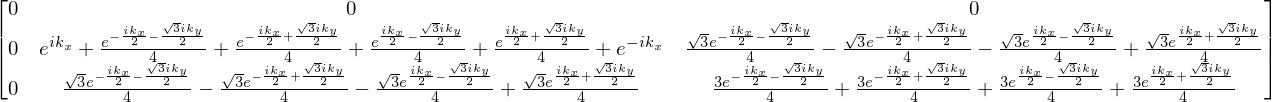

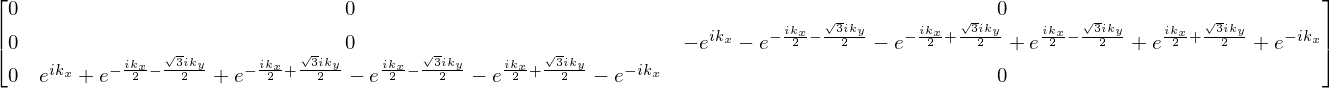

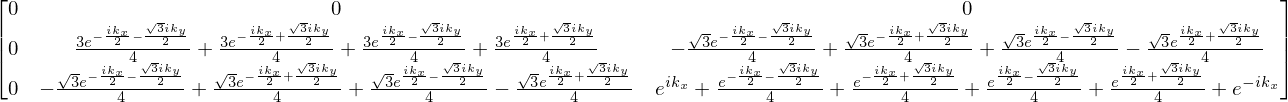

In [28]:
qsymm.display_family(family, nsimplify=True)

In [29]:
fam = hamiltonian_from_family(family, tosympy=False)

In [30]:
# Atomic coordinates within the unit cell
atom_coords = [(0, 0)]
lat_vecs = [(1, 0), (1/2, np.sqrt(3)/2)]

In [31]:
syst = bloch_model_to_builder(fam, norbs, lat_vecs, atom_coords)
syst = bloch_family_to_builder(family, norbs, lat_vecs, atom_coords)

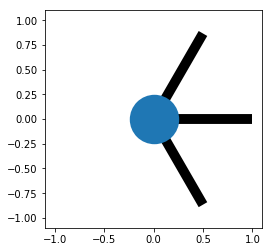

In [32]:
kwant.plot(syst);

In [33]:
ham2 = builder_to_model(syst).tomodel(nsimplify=True)
assert fam == ham2

Compare model after transforming back with wraparound's convention

In [34]:
from qsymm.linalg import allclose

ham2 = builder_to_model(syst, unit_cell_convention=True).tomodel(nsimplify=True)

# Check that the Hamiltonians are identical at random points in the Brillouin zone
syst = bloch_model_to_builder(fam, norbs, lat_vecs, atom_coords)
wrapped = kwant.wraparound.wraparound(syst).finalized()
H1 = wrapped.hamiltonian_submatrix
H2 = ham2.lambdify()
coeffs = 0.5 + np.random.rand(8)
for _ in range(20):
    kx, ky = 3*np.pi*(np.random.rand(2) - 0.5)
    params = {**{'c'+str(i): val for i, val in enumerate(coeffs)}, 'k_x': kx, 'k_y': ky}
    h1, h2 = H1(params=params), H2(**params)
    assert allclose(h1, h2), (h1, h2)


### Test square lattice

In [35]:
s = qsymm.groups.spin_matrices(1/2)

# Time reversal
TR = qsymm.PointGroupElement(sympy.eye(2), True, False,
                             qsymm.groups.spin_rotation(2 * np.pi * np.array([0, 1/2, 0]), s))

# Mirror symmetry 
Mx = qsymm.PointGroupElement(sympy.Matrix([[-1, 0], [0, 1]]), False, False,
                             qsymm.groups.spin_rotation(2 * np.pi * np.array([1/2, 0, 0]), s))

# Fourfold
C4 = qsymm.PointGroupElement(sympy.Matrix([[0, 1], [-1, 0]]), False, False,
                             qsymm.groups.spin_rotation(2 * np.pi * np.array([0, 0, 1/4]), s))

symmetries = [TR, Mx, C4]

In [36]:
# One site per unit cell (M atom), with three orbitals
norbs = OrderedDict({'M': 2})

In [37]:
# Hopping to a neighbouring atom one primitive lattice vector away
hopping_vectors = [('M', 'M', [1, 0])]

In [38]:
family = qsymm.bloch_family(hopping_vectors, symmetries, norbs)

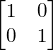

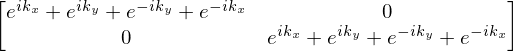

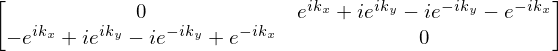

In [39]:
qsymm.display_family(family, nsimplify=True)

In [40]:
fam = hamiltonian_from_family(family, tosympy=False)

In [41]:
# Atomic coordinates within the unit cell
atom_coords = [(0, 0)]
lat_vecs = [(1, 0), (0, 1)]

In [42]:
syst = bloch_model_to_builder(fam, norbs, lat_vecs, atom_coords)
syst = bloch_family_to_builder(family, norbs, lat_vecs, atom_coords)

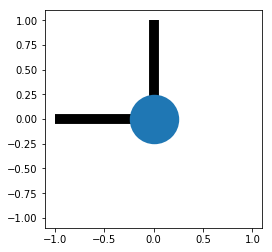

In [43]:
kwant.plot(syst);

In [44]:
ham2 = builder_to_model(syst).tomodel(nsimplify=True)
assert fam == ham2

In [45]:
sysw = kwant.wraparound.wraparound(syst).finalized()

In [46]:
pars=dict(k_x=0, k_y=0.1, c0=0, c1=1, c2=1)

In [47]:
H = sysw.hamiltonian_submatrix

In [48]:
H2 = ham2.lambdify()
H3 = fam.lambdify()

In [49]:
%timeit H2(**pars)

7.12 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [50]:
%timeit H(params=pars)

122 µs ± 5.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
